In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random

data_folder = "/home/wenceslai/Documents/predict_sales_kaggle"

df_train = pd.read_csv(os.path.join(data_folder, 'sales_train.csv'))


df_itemcats = pd.read_csv(os.path.join(data_folder, 'items.csv'))
df_itemcats = df_itemcats.drop('item_name', axis=1)

df_sub = pd.read_csv(os.path.join(data_folder, 'sample_submission.csv'))

In [2]:
def downcast_dtypes(df):
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

#correlation matrix
corr = df_train.corr()
sns.heatmap(data=corr, square=True, annot=True, fmt='.2f')

#df_train.plot.scatter(x='shop_id', y='item_price')

In [47]:


#gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day': ['sum']})
#gb.columns = ['month_sum']

#df_train = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)


In [57]:
#aggregating average price and monthly sales
prices = df_train.groupby('item_id').agg({'item_price' : ['mean']})
prices.columns = ['avg_price']
prices = prices.reset_index()
prices = prices[['item_id', 'avg_price']]

In [55]:
sales.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


In [ ]:
from itertools import product
sales = df_train.copy()
index_cols = ['shop_id', 'item_id', 'date_block_num']

grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
df_train = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

month_sums = .groupby(['shop_id', 'item_id', 'date_block_num']).agg({'item_cnt_day' : ['sum']})
month_sums.columns = ['month_sum']
month_sums.reset_index(inplace=True)

df_train = df_train.merge(month_sums, on=index_cols, how='left')

df_train = df_train.merge(prices, on='item_id', how='left') #prices

df_train = df_train.merge(df_itemcats, on='item_id', how='left') #item categories

df_train['month'] = df_train['date_block_num'] % 12

df_train = df_train[['date_block_num', 'month', 'shop_id',  'item_category_id', 'item_id', 'avg_price', 'month_sum']]
df_train.head()

In [3]:
#aggregating average price and monthly sales
prices = df_train.groupby('item_id').agg({'item_price' : ['mean']})
prices.columns = ['avg_price']
prices = prices.reset_index()
prices = prices[['item_id', 'avg_price']]

df_train = df_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day' : ['sum']})
df_train.columns = ['month_sum']
df_train = df_train.reset_index()

df_train = df_train.merge(prices, on='item_id', how='left') #prices

df_train = df_train.merge(df_itemcats, on='item_id', how='left') #item categories

df_train['month'] = df_train['date_block_num'] % 12

df_train = df_train[['date_block_num', 'month', 'shop_id',  'item_category_id', 'item_id', 'avg_price', 'month_sum']]
df_train.head()

,date_block_num,month,shop_id,item_category_id,item_id,avg_price,month_sum
0,0,0,0,40,32,249.629240,6.0
1,0,0,0,37,33,252.831928,3.0
2,0,0,0,40,35,375.828056,1.0
3,0,0,0,40,43,167.222222,1.0
4,0,0,0,57,51,265.708333,2.0


In [4]:
#test data frame
#date_block_num 	shop_id 	item_id 	month_sum 	item_category_id 	item_price
df_test = pd.read_csv(os.path.join(data_folder, 'test.csv'))

df_test['date_block_num'] = 34
df_test['month'] = 34 % 12

df_test = df_test.merge(df_itemcats, on='item_id', how='left')

#avg_prices = avg_prices.drop_duplicates() #average prices of items
#avg_prices_train = avg_prices.groupby('item_id')['avg_price'].mean()

df_test = df_test.merge(prices, on='item_id', how='left')

df_test = df_test.sort_values(by=['ID'])

df_test['avg_price'] = df_test['avg_price'].fillna(-999)

df_test = df_test[['date_block_num', 'month', 'shop_id', 'item_category_id', 'item_id', 'avg_price']]

assert df_test.shape[-1] == df_train.shape[-1] - 1
print(df_test.isnull().sum())
df_test.head()

date_block_num      0
month               0
shop_id             0
item_category_id    0
item_id             0
avg_price           0
dtype: int64


,date_block_num,month,shop_id,item_category_id,item_id,avg_price
0,34,10,5,19,5037,1926.828388
1,34,10,5,55,5320,-999.000000
2,34,10,5,19,5233,800.777500
3,34,10,5,23,5232,790.512923
4,34,10,5,20,5268,-999.000000


In [89]:
all_data = pd.concat([df_train, df_test])
all_data = downcast_dtypes(all_data)

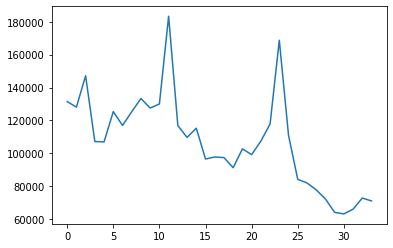

In [90]:
M_sales = df_train.groupby('date_block_num')['month_sum'].sum()
plt.plot(range(34), M_sales)

# Lag features

In [91]:
def lag_features(df, lags, col):
    subset = df[['date_block_num', 'shop_id', 'item_id', col]]
    for lag in lags:
        shifted = subset.copy()
        #shifted.cols = [['date_block_num', 'shop_id', 'item_id', col+"_lag_"+str(lag)]]
        shifted.rename(columns={col : col+"_lag_"+str(lag)}, inplace=True)
        shifted['date_block_num'] += lag
        df = df.merge(shifted, on=['date_block_num', 'shop_id', 'item_id'], how='left').fillna(0)
    del shifted
    
    return df

In [92]:
lags = [1, 2, 3, 4, 5, 12]

all_data = lag_features(all_data, lags, 'month_sum')

In [94]:
df_train = all_data[all_data.date_block_num <= 33]
df_test = all_data[all_data.date_block_num == 34].drop('month_sum', axis=1)

# Training

In [5]:
df_train = df_train.drop('avg_price', axis=1)
df_test = df_test.drop('avg_price', axis=1)

In [6]:
X = df_train.drop('month_sum', axis=1).values

y = df_train['month_sum'].values
y = y.clip(0., 20.)

print(X.shape, y.shape)

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.999)



(1609124, 5) (1609124,)


In [8]:
val_tresh = 33

X_train = df_train.loc[df_train['date_block_num'] < val_tresh].drop('month_sum', axis=1).values
y_train = df_train.loc[df_train['date_block_num'] < val_tresh]['month_sum'].values


X_val = df_train.loc[df_train['date_block_num'] == val_tresh].drop('month_sum', axis=1).values
y_val = df_train.loc[df_train['date_block_num'] == val_tresh]['month_sum'].values

y_train = y_train.clip(0, 20)
y_val = y_val.clip(0, 20)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(1577593, 5) (1577593,) (31531, 5) (31531,)


In [21]:
df_train.head()

,date_block_num,month,shop_id,item_category_id,item_id,month_sum
0,0,0,0,40,32,6.0
1,0,0,0,37,33,3.0
2,0,0,0,40,35,1.0
3,0,0,0,40,43,1.0
4,0,0,0,57,51,2.0


In [18]:
#baseline: 1.41
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(n_jobs=-1, verbose=1, n_estimators=50, max_depth=15, random_state=18) #rs was 18
model_rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.3min finished


RandomForestRegressor(max_depth=20, n_estimators=150, n_jobs=-1,
                      random_state=18, verbose=1)

In [35]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train.ravel(), verbose=1)

[10:14:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

# Validation

In [19]:
from sklearn.metrics import mean_squared_error

y_preds = model_rf.predict(X_val).clip(0, 20)

rmse = np.sqrt(mean_squared_error(y_val, y_preds))
print("validation RMSE:", rmse)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.1s finished
validation RMSE: 2.291548111741943


In [20]:
from sklearn.metrics import mean_squared_error

y_preds = model_rf.predict(X_train).clip(0, 20)

rmse = np.sqrt(mean_squared_error(y_train, y_preds))
print("validation RMSE:", rmse)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
validation RMSE: 1.4941490080353448
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    5.0s finished


In [20]:
X_test = df_test.values

preds = model_rf.predict(X_test).clip(0, 20)

df_sub['item_cnt_month'] = np.round(preds)#round?
df_sub.to_csv(os.path.join(data_folder, 'sub_out_lags'), index=False)
print("done")

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


done


In [105]:
"""
k = df_train['date_block_num'].nunique()
win_size = X_train.shape[0] // k
rmses = []

for i in range(k - 1):
    X_train_part = X_train[(i + 1) * win_size:(i + 2) * win_size]
    y_train_part = y_train[(i + 1) * win_size:(i + 2) * win_size]
    X_val = X_train[i * win_size:(i + 1) * win_size]
    y_val = y_train[i * win_size:(i + 1) * win_size]

    #model.fit(X_train_part, y_train_part.ravel())
    y_preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_preds))
    rmses.append(rmse)

print(rmses, "\navg rmse:", sum(rmses) / len(rmses))
"""

ValueError: Found array with 0 sample(s) (shape=(0, 12)) while a minimum of 1 is required.

In [32]:
df_train[(df_train.item_id == 32) & (df_train.shop_id == 29)].shape

(12, 6)

In [33]:
df_train.shape

(1609124, 6)

In [107]:
X_test = df_test.values

preds = model_rf.predict(X_test)

df_sub['item_cnt_month'] = np.round(preds)#round?
df_sub.to_csv(os.path.join(data_folder, 'sub_out_lags'), index=False)
print("done")

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


done


In [ ]:
"""
k = df_train['date_block_num'].nunique()
win_size = X_train.shape[0] // k
rmses = []

for i in range(k - 1):
    X_train_part = X_train[(i + 1) * win_size:(i + 2) * win_size]
    y_train_part = y_train[(i + 1) * win_size:(i + 2) * win_size]
    X_val = X_train[i * win_size:(i + 1) * win_size]
    y_val = y_train[i * win_size:(i + 1) * win_size]

    #model.fit(X_train_part, y_train_part.ravel())
    y_preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_preds))
    rmses.append(rmse)

print(rmses, "\navg rmse:", sum(rmses) / len(rmses))
"""